# CM50268 :: Lab 1 :: Bayesian Linear Regression

**Total Marks 20 (20% of overall unit marks).**

*Submission deadline: 6pm, Friday February 28, 2020.*

## Overview

This lab focuses on implementing some of the requisite calculations and manipulations for applying Bayesian linear regression models of the type covered in Lectures 3 and 4.

Exercises include:

- computing the posterior distribution,
- computing the marginal likelihood,
- evaluating and choosing regularisation parameters,
- obtaining posterior mean models,
- calculating error-bars (the predictive variance), and,
- ... some presentation of results.

As in the lectures, the data will be derived from a synthetic, noisy, sine wave and our model will be a linearly-weighted set of "Gaussian" (RBF) basis functions. In a change from the lectures, a modification has been made to the data: there are no observations from one particular region of the data space. One of the aims of the lab is to see how this aspect impacts on the uncertainty of the model predictions.

There are 3 principal tasks (detailed below), with varying marks. In summary here:

1. Fit various Gaussian RBF-based linear models to the training data using penalised least-squares, and visualise the results (6 marks),
2. Replicate slide 17/21 of Lecture 4 for the model and data here  - that is, compute the train, validation and test set errors, plus the marginal likelihood (the red dashed curve in slide 17), over a range of $\lambda$ (or $\alpha$) values (11 marks),
3. Identify the best posterior mean model, visualise it along with its error-bars (predictive variance), and consider how those error-bars might be usefully exploited (3 marks + 2 bonus marks for the open question).


## Submission & Marking

This lab exercise is assessed, and the marks will contribute to your final grade. For this lab exercise there are a number of places where you are expected to enter your own code. Every place you have to add code is described in the text and specifically indicated by the comment:

`#### **** YOUR CODE HERE **** ####`


There is also one place where you are asked to enter explanatory text. Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle before 6pm on February 28, 2020**. The workbook you submit must be an `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and Checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them.

**You should take care to avoid any suggestion of plagiarism in your submission.** There is helpful information on how to avoid plagiarism on the University website: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

## Setup

### Support code

To get started, the code cell below imports the requisite standard Python modules, plus a setup module `cm50268_lab1_setup` specific to this lab. This module contains:

- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian "RBF" basis matrices for varying data sets,
- the function `error_rms` to simply calculate errors for a given target values $t$ and corresponding model output $y$.

We also set some "constants" below: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.1$ for the entire exercise.


In [1]:
%matplotlib inline
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Lab-specific support module
import cm50268_lab1_setup as lab1
#
N_train = 12
N_val   = N_train
N_test  = 250
#
sigma = 0.1
s2    = sigma**2


### Generate Data
We synthesise three data sets:
- training set of size $N_{train}=12$ with added noise $\sigma=0.1$
- validation set of size $N_{val}=12$ with added noise $\sigma=0.1$
- test set of size $N_{test}=250$ with **no noise** and which **covers the full $x$-space**

**Note:** we assume throughtout that $\sigma$ is known and fixed. A feature of the test set here is that *it will include data from a region where there is no training data*.

### Generate Basis
For our linear model, we use as many functions as data points (a "complete" basis), comprising $N-1$ equally-spaced Gaussian functions (of width 1), plus a fixed "bias" or "offset". If we call `evaluate` on the basis generator, we get a $N\times{}M$ matrix $\mathbf{\Phi}$ returned, where each column / row contains the output of each basis function on each data point respectively: that is, $\mathbf{\Phi}_{nm} = \phi_m(x_n)$. The use of a bias means the first column contains simply a fixed value of one. 

For the training and validation set, this matrix $\mathbf{\Phi}$ will be $12\times 12$, whereas for the test set it will be $250 \times 12$.

For illustration, the data and the underlying "truth" (sine wave) are shown below, with basis functions overlaid.

<img src="data-and-basis.png" alt="Data and basis" style="width: 500px;"/>


In [2]:
# Data - create generator instance, and synthesise 3 sets
#
generator = lab1.DataGenerator(noise=sigma)
#
(x_train, t_train) = generator.get_data('TRAIN', N_train)
(x_val, t_val) = generator.get_data('VALIDATION', N_val)
(x_test, t_test) = generator.get_data('TEST', N_test)

# Basis - create generator instance and compute the basis matrices for all 3 data sets
# Note that because we use a "bias" function, we need N-1 Gaussians to make the
# basis "complete" (i.e. for M=N)
#
M = N_train-1
r = 1 # Basis radius or width
centres = np.linspace(generator.xmin, generator.xmax, M)
basis = lab1.RBFGenerator(centres, width=r, bias=True)
#
PHI_train = basis.evaluate(x_train)
PHI_val = basis.evaluate(x_val)
PHI_test = basis.evaluate(x_test)


## Task 1a 
**(3 marks)**

Write a function `fit_pls` (its signature is defined in the cell below) to fit a linear model with basis matrix `PHI_train` to the training data `t_train` for a given value of regularisation parameter $\lambda$. It should return the weight vector $\mathbf{w}_{PLS}$ that minimises the penalised least squares error.

You may find the functions `np.linalg.lstsq` and/or `np.linalg.inv` applicable.

The ideal solution will treat the $\lambda=0$ case differently to $\lambda>0$.


In [3]:
## FIT_PLS
##
def fit_pls(PHI, t, lam):
    #
    #### **** YOUR CODE HERE **** ####
    x=PHI
    y=t
    
    transpose_x=np.transpose(x)
    
    a=np.matmul(transpose_x,x)
    b=lam*np.identity(a.shape[0])
    c=np.matmul(transpose_x,y)
    
    w=np.matmul(np.linalg.inv(a+b),c)
    w=np.squeeze(w)
    return w


## Task 1b
**(3 marks)**

First, write a convenient graphing function `plot_regression` that you will need for this and following tasks. It should be capable of being passed suitable arguments to plot on the same axes:

- the data (*i.e.* `t_train` above),
- the generating function (*i.e.* the noise-free `t_test` above),
- some approximating function, or predictor, $y$ (you will compute some shortly).

A simple example of output is shown below. You are welcome to choose your own consistent styles (indeed, are encouraged to!), and need not follow mine.

<img src="regression.png" alt="Data and Predictor" style="width: 500px;"/>

Using `fit_pls` in conjunction with `plot_regression`, add code below to plot three graphs for values of $\lambda$ in \[ 0, 0.01, 10\]. In each graph (appropriately labelled by $\lambda$), show:

1. the training data (`x_train` / `t_train`)
2. the underlying generating function (by plotting `x_test` / `t_test`)
3. your fitted function at points `x_test` (you will need to multiply the relevant $\mathbf{\Phi}$ by $\mathbf{w}_{PLS}$)

You should find that the first $\lambda$ value over-fits, the second is "about right" (but only where there is data!) and the third under-fits.


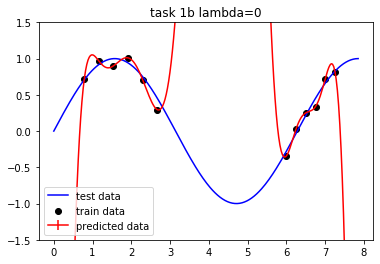

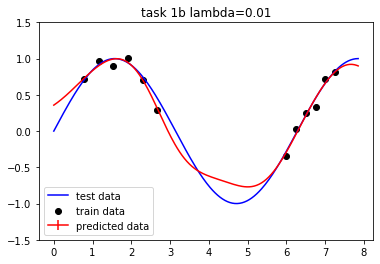

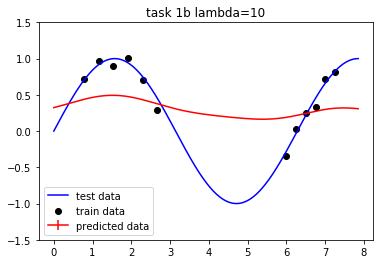

In [4]:
#### **** YOUR CODE HERE **** ####
#task1b
def plot_regression(x_train,y_train,x_test,y_test,y_pred,title,variance=0):
 
    plt.figure(title)
    plt.title(title)
    plt.scatter(x_train,y_train,label="train data",c="black")
    plt.plot(x_test,y_test,label="test data",c="blue")
    #plt.plot(x_test,y_pred,label="predicted data",c="red")
    plt.errorbar(x_test, y_pred, variance,label="predicted data",c="red")
    plt.ylim([-1.5,1.5])
    plt.legend()
    plt.show()
 
for lam in [0,0.01,10]:
    title="task 1b lambda="+str(lam)
    weight=fit_pls(PHI_train, t_train, lam)
    y_pred=(weight*PHI_test).sum(axis=1)
    plot_regression(x_train,t_train,x_test,t_test,y_pred,title)

## Task 2a
**(2 marks)**

Write a function `compute_posterior` to compute the posterior mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

Verify the consistency of your posterior code with `fit_pls` by comparing the outputs `w` and `Mu` (they should be the same, remembering that for equivalence, $\alpha = \lambda/\sigma^2$). As well as defining your function below, append a few lines of code underneath which show your consistency check for $\lambda=0.01$.


In [5]:
## POSTERIOR
##
def compute_posterior(PHI, t, alph, s2):
    #### **** YOUR CODE HERE **** ####
    x=PHI
    y=t
    lam=alph*s2
    
    transpose_x=np.transpose(x)
    
    a=np.matmul(transpose_x,x)
    b=lam*np.identity(a.shape[0])
    c=np.matmul(transpose_x,y)
    
    Mu=np.matmul(np.linalg.inv(a+b),c)
    Mu=np.squeeze(Mu)
    
    SIGMA=s2*(np.linalg.inv(a+b))
    return Mu, SIGMA
lam=0.01
weight=fit_pls(PHI_train, t_train, lam)
alph=lam/s2
mu,sigma=compute_posterior(PHI_train, t_train, alph, s2)
print("check : ",np.isclose(mu,weight).all())


check :  True


## Task 2b
**(3 marks)**

Write a function `compute_log_marginal` to compute the *logarithm* of the marginal likelihood for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

In Lecture 4, slide 11 and 12 we have illustrated the equations of finding the most probable hyperparameters to maximise the likelihood with respect to the hyperparameters (in slide 12). The likelihood of the hyperparameters can also be treated as the evidence with respect to $\mathbf{w}$. 

In our lab 1 example, the integral form of evidence computation (in slide 12) can be rewritten as follows:

$p(\mathbf{t}|\alpha, \sigma^2) = (2 \pi)^{-\frac{N}{2}} |\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top}|^{-\frac{1}{2}} \exp\{ -\frac{1}{2} \mathbf{t}^{\top} (\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top})^{-1} \mathbf{t}  \}$

In principle, you may wish to use `stats.multivariate_normal.logpdf` (don't compute the pdf and then call `np.log`!).

In practice, you should not have numerical issues using `stats.multivariate_normal.logpdf` (this can happen if you experiment with larger data sets, in which case you may wish to look at the `allow_singular` argument.)

There is an alternative, and more robust, way of calculating the marginal likelihood directly, which you may wish to explore if you are comfortable with linear algebra and matrix identities. (**1 mark** reserved for this.)


In [6]:
## MARGINAL LIKELIHOOD
##
def compute_log_marginal(PHI, t, alph, s2):
    #### **** YOUR CODE HERE **** ####
    a=np.matmul(PHI,np.transpose(PHI))
    a=a/alph
    covariance=(s2*np.identity(a.shape[0]))+a
    
    lgp=stats.multivariate_normal.logpdf(np.squeeze(t),cov=covariance)     
    return lgp


# Task 2c
**(4 marks)**

In the cell below, write some code to replicate slide 15 of Lecture 4 for the Gaussian RBF basis and the `t_train` data defined above. Here is a reminder of the relevant graph:

<img src="slide15.png" alt="Slide 15 from Lecture 4" style="width: 400px;"/>

In more detail, over a range of $\lambda$ (or equivalent $\alpha=\lambda/\sigma^2$) values, you should:

- Compute the train, validation and test set errors for the penalised least-squares model (use your `fit_pls` to fit it, and the supplied `error_rms` to calculate the error). 
- Also compute the *negative* log marginal likelihood, using the function just written.
- Plot all these curves on the same graph, noting that the scale for the errors is different for that of the negative log marginal likelihood.
- In addition to plotting the graph below, add code to compute, and output (using `print`), the *test error* corresponding to the minimum point on: (1) the test error curve itself, (2) the validation curve, (3) the negative marginal likelihood curve.

For easiest interpretation, I would suggest defining your $\lambda$ range logarithmically. First use `np.linspace(begin,end,steps)` to create equally spaced values `v`, then specify `lambda = 10**v`. For `steps`, a value of 100 would work well.

You should find that your graph has a similar qualitative form to that in the lecture slides (and shown above), although the test error curve looks rather "sharp".

**Hints:** 
- You can create a new $y$-axis on the same plot, which shares the $x$-axis, using `plt.gca().twinx()`.
- Remember that $\alpha=\lambda/\sigma^2$. If you don't rescale appropriately, the marginal likelihood curve will not be correctly aligned with the error curves and your minimum point will be incorrect.


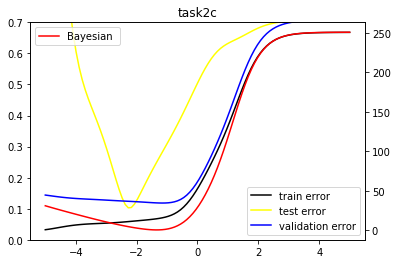

min test error :  0.10294116860808597
min val error :  0.28109676107280784
min bayesian (neg log marginal) error :  0.2456770627480867


In [7]:
#### **** YOUR CODE HERE **** ####
def error_rms(y_pred,y_test):
    rmse=np.sqrt(np.mean((y_pred-y_test)**2))
    return rmse

log_lambda_value_to_try=np.linspace(-5,5,100)


train_rmse_list=[]
test_rmse_list=[]
val_rmse_list=[]
negative_log_likelihood_list=[]
alpha_list=[]
for log_lambda in log_lambda_value_to_try:
    lam=10**log_lambda
    #OLS
    weight=fit_pls(PHI_train, t_train, lam)
    train_pred=(weight*PHI_train).sum(axis=1)
    test_pred=(weight*PHI_test).sum(axis=1)
    val_pred=(weight*PHI_val).sum(axis=1)
    
    train_rmse_list.append(error_rms(train_pred,np.squeeze(t_train)))
    test_rmse_list.append(error_rms(test_pred,np.squeeze(t_test)))
    val_rmse_list.append(error_rms(val_pred,np.squeeze(t_val)))
    
    #Bayesian
    alph=lam/s2
    alpha_list.append(alph)
    log_maginal=compute_log_marginal(PHI_train, t_train, alph, s2)
    negative_log_likelihood_list.append(log_maginal*-1)
    
plt.figure("task2c")
plt.title("task2c")
plt.ylim([0,0.7])
plt.plot(log_lambda_value_to_try,train_rmse_list,label="train error",c="black")
plt.plot(log_lambda_value_to_try,test_rmse_list,label="test error",c="yellow")
plt.plot(log_lambda_value_to_try,val_rmse_list,label="validation error",c="blue")
plt.legend()
plt.gca().twinx()
#plt.ylim([-3,5])
plt.plot(log_lambda_value_to_try,negative_log_likelihood_list,label="Bayesian ",c="red")
plt.legend()
plt.show()

#compute lowest error
#find index of lowest point
min_index_test=test_rmse_list.index(min(test_rmse_list))
min_index_val=val_rmse_list.index(min(val_rmse_list))
min_index_bayesian=negative_log_likelihood_list.index(min(negative_log_likelihood_list))

print("min test error : ",test_rmse_list[min_index_test])
print("min val error : ",test_rmse_list[min_index_val])
print("min bayesian (neg log marginal) error : ",test_rmse_list[min_index_bayesian])


# Task 2d
**(2 marks)**

Find the best value of $\alpha$ according to the marginal likelihood in Task 2c above, call `compute_posterior` to find the posterior mean weight vector `Mu` and use this to compute the posterior mean predictor (*i.e.* $y=\Phi\mu$) at all the test points `x_test`. Then, similar to Task 1b, using your earlier `plot_regression` function, plot on the same axes:
1. the training data (`x_train` / `t_train`),
2. the underlying generating function (by plotting `x_test` and `t_test`),
3. the posterior mean predictor function you just calculated.

You should find that the predictor is a pretty good fit to the underlying generating function *where there was data in the training set*. We can't expect the model to make good predictions in the "gap" where it has not seen any training data (unless it gets lucky!).


best alpha for bayesian :  4.3287612810830565


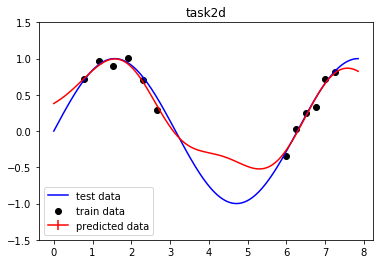

In [8]:
#### **** YOUR CODE HERE **** ####
title="task2d"
alph=(10**log_lambda_value_to_try[min_index_bayesian])/s2
print("best alpha for bayesian : ",alph)
mu,sigma=compute_posterior(PHI_train, t_train, alph, s2)
y_pred=(mu*PHI_test).sum(axis=1)

plot_regression(x_train,t_train,x_test,t_test,y_pred,title)

# Task 3a
**(3 marks)**

Repeat the graph above (Task 2d), for the same "best" predictor, but this time also compute the predictive variance at the points `x_test` and add them to the same plot as "error bars".

**Notes:**

- By "error bars" we mean some multiple of the predictive standard deviation, and a multiple of 1 is fine, though other choices (*e.g.* 1.96 or 2.0) can be applicable,
- To compute the predictive variance at `x_test`, you'll need the matrix `PHI_test`,
- The matplotlib function `plt.fill_between` is a handy utility for plotting error bars (though you don't have to use it),
- If your calculations are correct, you should expect to see larger error bars where there is no data.

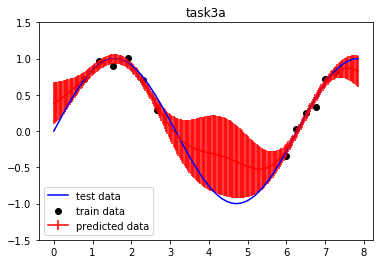

In [9]:
#### **** YOUR CODE HERE **** ####
mu,sigma=compute_posterior(PHI_train, t_train, alph, s2)
variance=np.matmul((PHI_test),sigma)
variance=(variance*PHI_test).sum(axis=1)
sd=np.sqrt(variance)

title="task3a"
y_pred=(mu*PHI_test).sum(axis=1)
plot_regression(x_train,t_train,x_test,t_test,y_pred,title,sd)

# Task 3b (bonus open-ended question)
**(2 marks)**

This is a more open-ended question, with an opportunity to think more creatively. (Note that there are only two marks available though.)

Imagine you had built the above model for inclusion within some real-world system where it was desired to make predictions at some arbitrary points $x$ in the future. How might the information from your model's predictive variance be useful in the practical application?

Remember that the predictive model is an $x$-dependent Gaussian distribution over the prediction, and in principle the variance quantifies the likely error (which is a consequence both of the noise on the data and any model uncertainty).

More specifically, your answer might look to address the following questions:

- how could the system exploit the predictive variance to practical advantage on new data?
- what evidence can you supply now (based on the existing test data set) to suggest the approach might work?

Explain what you might do in the text box below (no more than 200 words is suggested), and in the following box, generate whatever graph(s) you would offer as supporting evidence for the utility of your approach.


## Using the predictive variance in practice

**Add your explanation here.**



In [ ]:
#### **** YOUR CODE HERE **** ####
'''
1.help risk assessment : with some threshold, the company can choose to predict or not predict on that arbitary point x
    for example, if varinace at that point x is less than .... we will predict , if not we will not predict
    
2.confident interval : along side with the predited value, the confident interval can be determine with specific confident level
3.use to detemernine how much data is required : the minumum data point required in training set should reduce the level
    variance to certain value.
4.use to determine what data to collect more on certain range of attribute: since the middle part of the curve in task 
    3a shows wide standard deviation, this imply that more data should be collect for that range of x 
    (roughly 0 to 1, 3 to 6 and 7 to 8) to be used in training set...
'''